In [1]:
#####################
#####  Modules  #####
#####################

# Arrays and handling data
import numpy as np
import pandas as pd
import math

from astropy.io import fits # Astronomical files

# Plotting data
import matplotlib
from matplotlib import pyplot as plot
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Pulling data
import requests
import json
from urllib.parse import quote as urlencode   

import os # Accessing local files
import sys
import pickle

# Creating apertures
from photutils.aperture import EllipticalAperture
from photutils.aperture import aperture_photometry
from astropy.wcs import WCS # Converting between pixels and WCS

In [2]:
# Getting ra, dec and radius from TIC ID from the TIO Catalog

tic_ID = "TIC 155657581" # SIMBAD4 flickers really brightly so it should be easy to spot

ra = "206.395293725348"
dec = "79.3967479665581"
cutout_size = "600" # Arcseconds

radius = str(float(cutout_size) * float(math.sqrt(2)) / float(3600)) # Search radius. Cutout_size * root 2 / 2 for each side. Needs to be in decimal degrees 1/120 degrees
print(radius)

period = 0.3681414 #days

skip_count = 0
global skip_count
all_star_data = {}

0.23570226039551584


In [3]:
# Query using MAST to get the cone and all the stars inside the cone

def mast_query(request):
    request_url = "https://mast.stsci.edu/api/v0/invoke" # Base URL
    
    version = ".".join(map(str, sys.version_info[:3])) # Grab Python version
    
    headers = { # Create HTTP header variables
        "Content-type": "application/x-www-form-urlencoded",
        "Accept": "text/plain",
        "User-agent": "python-requests/" + str(version)
    }
    
    # Encoding the request as a JSON string
    req_string = json.dumps(request)
    req_string = urlencode(req_string)
    
    response = requests.post(str(request_url), data = "request=" + str(req_string), headers = headers) # Perform the HTTP request
    
    # Pull out the headers and response content
    head = response.headers # Content where head is the response HTTP headers
    content = response.content.decode("utf-8") # Returned data
    return head, content

def tic_advanced_search_position_rows():
    request = {"service": "Mast.Catalogs.Filtered.Tic.Position.Rows",
               "format": "json",
               "params": {
                   "columns": "*",
                   "filters": [],
                   "ra": float(ra),
                   "dec": float(dec),
                   "radius": float(radius)
               }
    }
    
    headers, out_string = mast_query(request)
    out_data = json.loads(out_string)
    dataframe = pd.DataFrame(out_data["data"])
    with open("847_length_cone.pkl", "wb") as my_file:
        pickle.dump(dataframe, my_file)
    
    return dataframe

In [4]:
def add_everything(dictionary_key, brightness, time_of_frame, median, offset, TESS_magnitude, image_filter): # Name, brightness, time, median, offset, magnitude, filter
    all_star_data[dictionary_key] = {"brightness": [], "time": [], "median": [], "offset": [], "TESS_magnitude": [], "filter": []}
    
    all_star_data[dictionary_key]["brightness"].append(brightness)
    all_star_data[dictionary_key]["time"].append(time_of_frame)
    all_star_data[dictionary_key]["median"].append(median)
    all_star_data[dictionary_key]["offset"].append(offset)
    all_star_data[dictionary_key]["TESS_magnitude"].append(TESS_magnitude)
    all_star_data[dictionary_key]["filter"].append(image_filter)
    
    with open(str(np.where(cone["ID"] == int(tic_ID.split()[1]))[0][0]) + "_3.pkl", "wb") as my_file:
        pickle.dump(all_star_data, my_file)


def get_brightness_and_offset(fits_image, px, py):
    mini_max_y, mini_max_x = np.unravel_index((fits_image[int(py)-10:int(py)+10, int(px)-10:int(px)+10]).argmax(), (fits_image[int(py)-10:int(py)+10, int(px)-10:int(px)+10]).shape) #fits_image.argmax(), fits_image.shape)
    max_x = int(px + (mini_max_x - 10))
    max_y = int(py + (mini_max_y - 10))
    ####print("(" + str(max_x) + ", " + str(max_y) + ")")
    
    testing_px = 0
    testing_py = 0
    while (max_x + testing_px) < len(fits_image[max_y]):
        if fits_image[max_y][max_x + testing_px] > np.median(fits_image):
            testing_px += 1
        else:
            break
    while (max_y + testing_py) < len(fits_image):
        if fits_image[max_y + testing_py][max_x] > np.median(fits_image):
            testing_py += 1
        else:
            break
    
    positions = [(px, py)]
    aperture = EllipticalAperture(positions, testing_px, testing_py, theta = 0.0)
    phot_table = aperture_photometry(fits_image, aperture, method = "exact")
    return float(phot_table[0]["aperture_sum"]), float(np.sqrt((max_x - px)**2 + (max_y - py)**2))


#def open_fits_file(target_w, fits_URL, mini_ra, mini_dec):
def open_fits_file(fits_URL, mini_ra, mini_dec):
    fits_file = fits.open(fits_URL) # fits can open URLS directly without needing to save the data as a .fits file")
    fits_image = np.array(fits_file[0].data)
    fits_header = fits_file[0].header
    target_w = WCS(fits_file[0].header)
    target_px, target_py = target_w.wcs_world2pix(float(mini_ra), float(mini_dec), 1)
    #px, py = target_w.wcs_world2pix(float(mini_ra), float(mini_dec), 1)
    print("Target pixels: (" + str(target_px) + ", " + str(target_px) + ")")
    print("WCS: (" + str(mini_ra) + ", " + str(mini_dec) + ") ")
    print("Picture size: " + str(len(fits_image[0])) + " by " + str(len(fits_image)))
    
    target_brightness, target_offset = get_brightness_and_offset(fits_image, target_px, target_py)
    print("Target brightness: " + str(target_brightness))
    add_everything("Target", target_brightness, float(fits_header["OBSJD"]), float(np.median(fits_image)), target_offset, cone.at[np.where(cone["ID"] == int(tic_ID.split()[1]))[0][0], "Tmag"], fits_header["filter"]) # Name, brightness, time, median, offset, magnitude, filter
    
    # go through each thing in cone (but for rn i will just do 103 and 108)
    #fake_cone = [103, 108, 98, 217, 218, 225, 281, 282, 283, 284, 285, 286, 287]
    for star_from_cone_index in range(len(cone)):
        print("Star: " + str(star_from_cone_index))
        star_from_cone_px, star_from_cone_py = target_w.wcs_world2pix(float(cone.at[star_from_cone_index, "ra"]), float(cone.at[star_from_cone_index, "dec"]), 1)
        #star_from_cone_px, star_from_cone_py = target_w.wcs_world2pix(float(cone.at[fake_cone[star_from_cone_index], "ra"]), float(cone.at[fake_cone[star_from_cone_index], "dec"]), 1)
        print("Star from cone pixels: (" + str(star_from_cone_px) + ", " + str(star_from_cone_py) + ")")
        
        if (float(star_from_cone_px) < 0) or (float(star_from_cone_py) < 0) or (float(star_from_cone_px) > len(fits_image[0])) or (float(star_from_cone_py) > len(fits_image)):
            print("Star " + str(star_from_cone_index) + " has to be skipped because it is not inside the cutout")
        else: # Star is in cutout
            skip_count = 0 # Needs to be in a row
            
            star_from_cone_brightness, star_from_cone_offset = get_brightness_and_offset(fits_image, star_from_cone_px, star_from_cone_py)
            print("Star from cone brightness: " + str(star_from_cone_brightness))
            add_everything(str(star_from_cone_index), star_from_cone_brightness, float(fits_header["OBSJD"]), float(np.median(fits_image)), star_from_cone_offset, cone.at[star_from_cone_index, "Tmag"], fits_header["filter"]) # Name, brightness, time, median, offset, magnitude, filter
            
            #'''
            figure, ax = plot.subplots()
            #ax.plot(px, py, "or")
            #ax.plot(max_x, max_y, "om")
            img = ax.imshow(fits_image, norm = matplotlib.colors.LogNorm()) # Log color scale to more easily see the contrast and see more stars. FLip the image data vertically to check with ds9
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size = "5%", pad = 0.05)
            colorbar = figure.colorbar(img, cax = cax, orientation = "vertical")
            colorbar.set_ticks([np.mean(fits_image), np.median(fits_image), 1000, 10000, np.max(fits_image), np.min(fits_image)])
            colorbar.set_ticklabels(["Mean: " + str(np.mean(fits_image)), "Median: " + str(np.median(fits_image)), str(1000), str(10000), "Max: " + str(np.max(fits_image)), "Min: " + str(np.min(fits_image))])
            #aperture_plot = matplotlib.patches.Ellipse((max_x, max_y), testing_px, testing_py, fill = False, color = "pink") #Circle((px, py), pixel_radius, color = "r", fill = False)
            #ax.add_patch(aperture_plot)
            ax.add_patch(matplotlib.patches.Circle((target_px, target_py), 7.5, fill = False, color = "pink"))
            ax.add_patch(matplotlib.patches.Circle((star_from_cone_px, star_from_cone_py), 7.5, fill = False, color = "orange"))
            plot.show()
            #'''
        
        #fits_file.close()
        
        #return float(phot_table[0]["aperture_sum"]), float(fits_header["OBSJD"]), float(np.median(fits_image)), float(np.sqrt((max_x - px)**2 + (max_y - py)**2)), fits_header["filter"]
    fits_file.close()
    print("..................")

In [5]:
#def get_ZTF_links(getting_target_w, star_number, mini_ra, mini_dec, cutout_size): # Download the ZTF image
def get_ZTF_links(star_number, mini_ra, mini_dec, cutout_size): # Download the ZTF image
    pd.set_option("display.max_columns", None)
    
    metadata_URL = "https://irsa.ipac.caltech.edu/ibe/search/ztf/products/sci?POS=" + str(mini_ra) + "," + str(mini_dec)
    metadata_response = requests.get(metadata_URL)
    save_table_name = "ogfile.txt" # All different stars from cone
    open(save_table_name, "wb").write(metadata_response.content)
    
    table = ""
    with open(save_table_name) as saved_table_file:
        lines = saved_table_file.readlines()
        headers = lines[90].replace(" ", "").split("|")[1:-1]
        headers.insert(19, "obstime") # Adding the times which are separated by spaces so pandas can use " " as a delimeter
        headers.insert(45, "ipac_pub_time")
        
        table = pd.read_table(save_table_name, skiprows = 94, names = headers, delim_whitespace = True) # After row 94 is the data, but 91 is the header
    
    lightcurve_data = {"brightness": [], "time": [], "median": [], "offset": []}
    w = 0
    skip_count = 0
    for picture_number in range(1): #len(table)): # For each frame for the lightcurve of the same picture -- same star, different time
        print("\n\n\nStar " + str(star_number) + "   Frame " + str(picture_number))
        
        file_fracday = str(table.at[picture_number, "filefracday"]) # yyyy + mm + dd + fracday
        year = str(file_fracday[:4]) # yyyy
        month = str(file_fracday[4:6]) # mm
        day = str(file_fracday[6:8]) # dd
        fracday = str(file_fracday[8:])
        padded_field = str("000" + str(table.at[picture_number, "field"])) # 000 + field
        filter_code = str(table.at[picture_number, "filtercode"])
        padded_ccdid = str(table.at[picture_number, "ccdid"]) # ccdid
        image_type_code = str(table.at[picture_number, "imgtypecode"]) # imgtypecode
        qid = str(table.at[picture_number, "qid"])
        suffix = "sciimg.fits" # Primary science image
        
        fits_URL = "https://irsa.ipac.caltech.edu/ibe/data/ztf/products/sci/" + str(year) + "/" + str(month) + str(day) + "/" + str(fracday) + "/ztf_" + str(file_fracday) + "_" + str(padded_field) + "_" + str(filter_code) + "_c" + str(padded_ccdid) + "_" + str(image_type_code) + "_q" + str(qid) + "_" + str(suffix) # Entire .fits file
        if not cutout_size == "":
            fits_URL += "?center=" + str(ra) + "," + str(dec) + "&size=" + str(cutout_size) + "arcsec&gzip=false" # For downloading .fits cutout
        
        # Saving the .fits file
        response = requests.get(str(fits_URL)) # I don't need the URL results because fits can open right from the URL
        try:
            open("SIMBAD4_Images/" + str(star_number) + "_3/ztf_" + str(file_fracday) + "_" + str(padded_field) + "_" + str(filter_code) + "_c" + str(padded_ccdid) + "_" + str(image_type_code) + "_q" + str(qid) + "_frame" + str(picture_number) + "_" + str(suffix), "wb").write(response.content) # Save .fits file
        except:
            print("Couldn't save .fits file")
        
        try:
            open_fits_file(fits_URL, float(mini_ra), float(mini_dec))
            #if getting_target_w:
            #    print("getting target_w")
            #    target_w, brightness, time, median, offset, image_filter = open_target_w_fits_file(fits_URL, float(mini_ra), float(mini_dec))
            #    lightcurve_data["brightness"].append(brightness)
            #    lightcurve_data["time"].append(time)
            #    lightcurve_data["median"].append(median)
            #    lightcurve_data["offset"].append(offset)
            #    lightcurve_data["filter"].append(image_filter)
            #    w = target_w
            #    getting_target_w = False
            #else:
            #    #print("normal star using target_w")
            #    #with open("SIMBAD4_target_w.pkl", "rb") as file:
            #    #    loaded_w = pickle.load(file)
            #    #    w = loaded_w
            #    #brightness, time, median, offset, image_filter = open_fits_file(w, fits_URL, float(mini_ra), float(mini_dec))
            #    brightness, time, median, offset, image_filter = open_fits_file(fits_URL, float(mini_ra), float(mini_dec))
            #    lightcurve_data["brightness"].append(brightness)
            #    lightcurve_data["time"].append(time)
            #    lightcurve_data["median"].append(median)
            #    lightcurve_data["offset"].append(offset)
            #    lightcurve_data["filter"] = image_filter
            #open_fits_file(fits_URL, float(mini_ra), float(mini_dec))
            #print("here")
        except ValueError as e:
            print("Failed and skipped: " + str(e))
            skip_count += 1
            if skip_count == 15: # If it breaks 10 times in a row, it probably isn't in the image
                break
    
    #return fits_URLs
    #return lightcurve_data

847
Target star is at index 342



Star 342   Frame 0
Target pixels: (297.4384818810641, 297.4384818810641)
WCS: (206.395293725348, 79.3967479665581) 
Picture size: 594 by 373
Target brightness: 321264.7192348744
Star: 0
Star from cone pixels: (887.136154243446, 644.3852123189938)
Star 0 has to be skipped because it is not inside the cutout
Star: 1
Star from cone pixels: (879.0026903747126, 643.3102978440784)
Star 1 has to be skipped because it is not inside the cutout
Star: 2
Star from cone pixels: (892.1404201925201, 628.2879392525921)
Star 2 has to be skipped because it is not inside the cutout
Star: 3
Star from cone pixels: (967.6239413681043, 507.65240189282486)
Star 3 has to be skipped because it is not inside the cutout
Star: 4
Star from cone pixels: (939.9901453744658, 505.89451539993956)
Star 4 has to be skipped because it is not inside the cutout
Star: 5
Star from cone pixels: (967.7867962030081, 484.2040939007052)
Star 5 has to be skipped because it is not inside the cutout


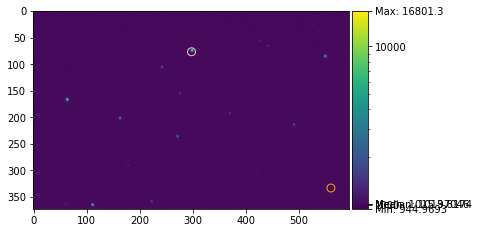

Star: 99
Star from cone pixels: (665.1224007513579, 305.22319281032446)
Star 99 has to be skipped because it is not inside the cutout
Star: 100
Star from cone pixels: (635.7275696030754, 270.2741726740303)
Star 100 has to be skipped because it is not inside the cutout
Star: 101
Star from cone pixels: (701.9057836531017, 201.99607629035654)
Star 101 has to be skipped because it is not inside the cutout
Star: 102
Star from cone pixels: (659.3214905691751, 80.90333509039033)
Star 102 has to be skipped because it is not inside the cutout
Star: 103
Star from cone pixels: (573.2747258690714, 64.68033037730493)
Star from cone brightness: 38895.35762720314


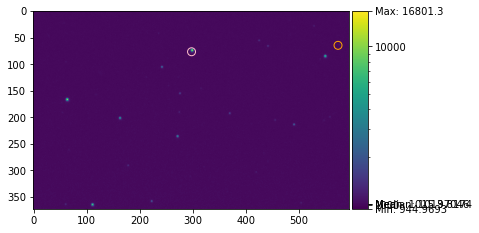

Star: 104
Star from cone pixels: (699.1425681652727, -22.39104187261546)
Star 104 has to be skipped because it is not inside the cutout
Star: 105
Star from cone pixels: (692.3930297216704, -32.82907268021131)
Star 105 has to be skipped because it is not inside the cutout
Star: 106
Star from cone pixels: (725.850134753133, -52.52408049624796)
Star 106 has to be skipped because it is not inside the cutout
Star: 107
Star from cone pixels: (613.9184682197391, -74.86651633143379)
Star 107 has to be skipped because it is not inside the cutout
Star: 108
Star from cone pixels: (579.0921009289577, -98.18102492478943)
Star 108 has to be skipped because it is not inside the cutout
Star: 109
Star from cone pixels: (652.4690807404571, -203.83802216701406)
Star 109 has to be skipped because it is not inside the cutout
Star: 110
Star from cone pixels: (718.4358842628076, -227.45948739557298)
Star 110 has to be skipped because it is not inside the cutout
Star: 111
Star from cone pixels: (602.677405116

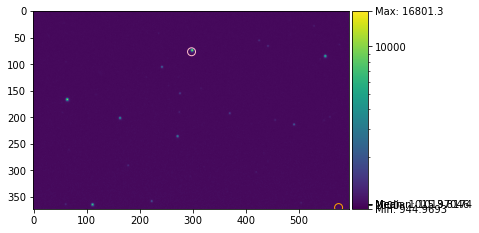

Star: 194
Star from cone pixels: (788.2735124608865, 588.5470388597658)
Star 194 has to be skipped because it is not inside the cutout
Star: 195
Star from cone pixels: (768.3088636655178, 520.0808228802257)
Star 195 has to be skipped because it is not inside the cutout
Star: 196
Star from cone pixels: (805.1166588701351, 554.5855810299856)
Star 196 has to be skipped because it is not inside the cutout
Star: 197
Star from cone pixels: (842.2068222227877, 551.7763191237857)
Star 197 has to be skipped because it is not inside the cutout
Star: 198
Star from cone pixels: (790.582586226111, 506.6654057701144)
Star 198 has to be skipped because it is not inside the cutout
Star: 199
Star from cone pixels: (747.0000109841359, 493.199272161919)
Star 199 has to be skipped because it is not inside the cutout
Star: 200
Star from cone pixels: (765.9900830853637, 480.2584932949637)
Star 200 has to be skipped because it is not inside the cutout
Star: 201
Star from cone pixels: (771.7643768704011, 424.

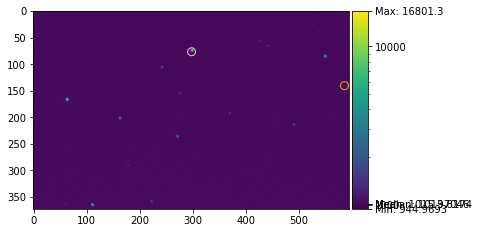

Star: 218
Star from cone pixels: (588.1452737768155, 135.529504783608)
Star from cone brightness: 57170.74716212059


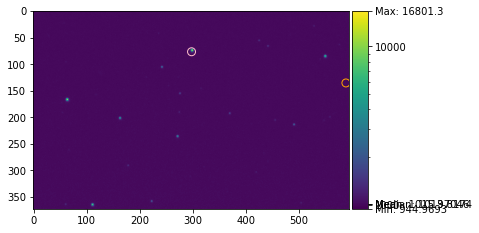

Star: 219
Star from cone pixels: (632.1596650655421, 147.91159128590834)
Star 219 has to be skipped because it is not inside the cutout
Star: 220
Star from cone pixels: (748.2852910221784, 148.35216972181001)
Star 220 has to be skipped because it is not inside the cutout
Star: 221
Star from cone pixels: (740.8454029500436, 178.87792839586677)
Star 221 has to be skipped because it is not inside the cutout
Star: 222
Star from cone pixels: (682.1706101030068, 54.86539851331554)
Star 222 has to be skipped because it is not inside the cutout
Star: 223
Star from cone pixels: (768.1347266622779, 56.54836000004866)
Star 223 has to be skipped because it is not inside the cutout
Star: 224
Star from cone pixels: (585.0201456610681, 51.87528247997784)
Star from cone brightness: 3180.134762531437


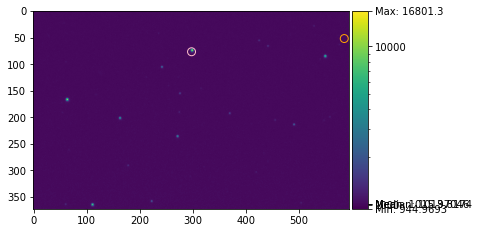

Star: 225
Star from cone pixels: (575.4545675697229, 46.74744896497532)
Star from cone brightness: 3238.9689727040204


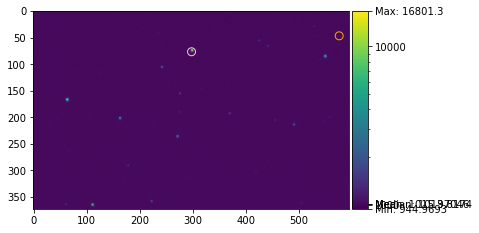

Star: 226
Star from cone pixels: (639.3477823264159, 24.36140265065842)
Star 226 has to be skipped because it is not inside the cutout
Star: 227
Star from cone pixels: (670.2242040998672, 27.10752404760001)
Star 227 has to be skipped because it is not inside the cutout
Star: 228
Star from cone pixels: (647.4882787669517, 8.262760247830784)
Star 228 has to be skipped because it is not inside the cutout
Star: 229
Star from cone pixels: (868.4889606159068, 208.8826585864174)
Star 229 has to be skipped because it is not inside the cutout
Star: 230
Star from cone pixels: (871.5315319545095, 135.62042688219117)
Star 230 has to be skipped because it is not inside the cutout
Star: 231
Star from cone pixels: (810.3803315627837, 74.80498296175188)
Star 231 has to be skipped because it is not inside the cutout
Star: 232
Star from cone pixels: (839.4118646316923, 20.313323732641265)
Star 232 has to be skipped because it is not inside the cutout
Star: 233
Star from cone pixels: (815.3279435333799, 

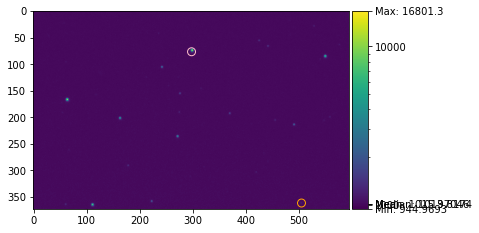

Star: 281
Star from cone pixels: (420.3613951222039, 303.9805120941178)
Star from cone brightness: 39695.89124573935


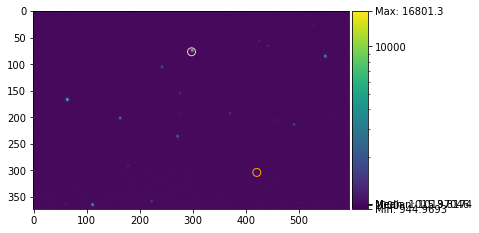

Star: 282
Star from cone pixels: (322.2944197345937, 294.29378025617166)
Star from cone brightness: 25899.792038842475


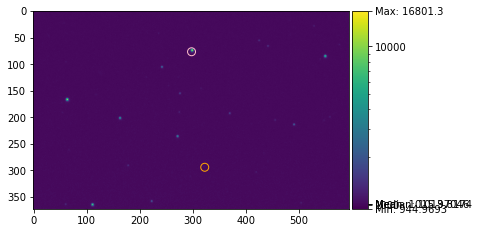

Star: 283
Star from cone pixels: (442.091753722666, 284.23167051967584)
Star from cone brightness: 64329.75654330638


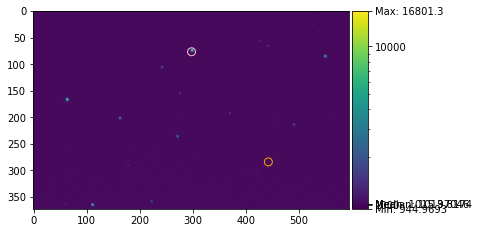

Star: 284
Star from cone pixels: (491.4725365568672, 214.73298922495542)
Star from cone brightness: 107579.47669325596


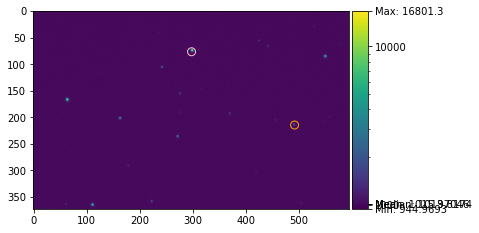

Star: 285
Star from cone pixels: (455.67546596959846, 206.66291345629747)
Star from cone brightness: 78704.13558109666


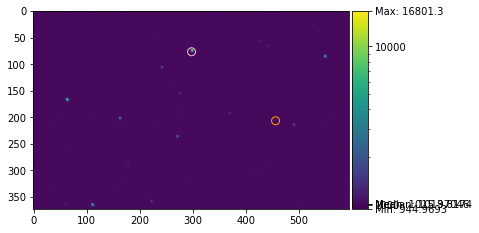

Star: 286
Star from cone pixels: (547.9652385284684, 207.0828750528717)
Star from cone brightness: 19750.846098663802


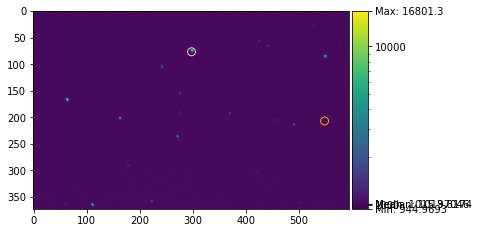

Star: 287
Star from cone pixels: (549.6785921848493, 202.79853629230456)
Star from cone brightness: 28858.05531956601


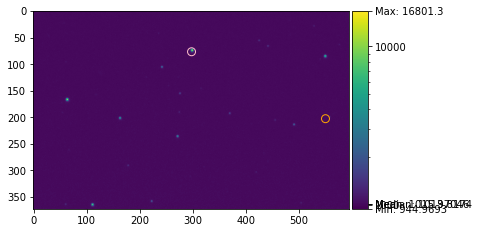

Star: 288
Star from cone pixels: (370.5984035714856, 193.82472350356034)
Star from cone brightness: 197356.3631796048


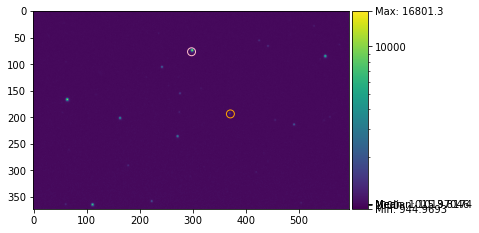

Star: 289
Star from cone pixels: (540.5585351085479, 92.17731065848625)
Star from cone brightness: 232373.26004703503


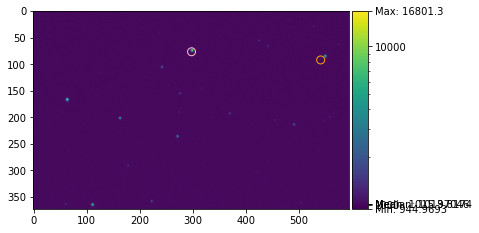

Star: 290
Star from cone pixels: (550.1497287656325, 86.79966035400957)
Star from cone brightness: 287764.60418980394


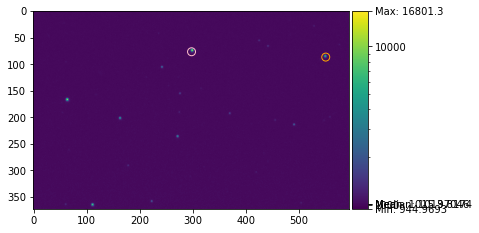

Star: 291
Star from cone pixels: (442.3485357954926, 67.77865552739718)
Star from cone brightness: 99513.15100715189


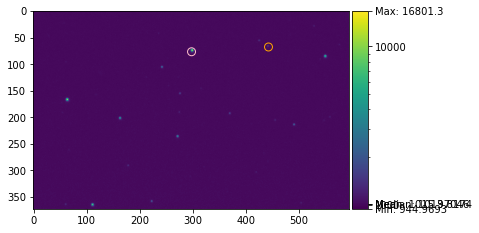

Star: 292
Star from cone pixels: (549.515908476139, 63.67325953245199)
Star from cone brightness: 3154.2930436318993


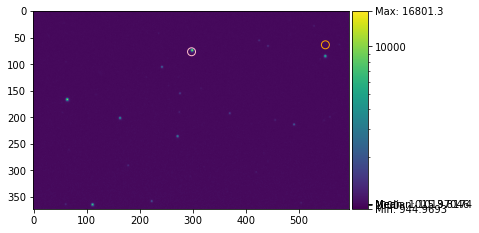

Star: 293
Star from cone pixels: (425.70115247697424, 57.16351975483758)
Star from cone brightness: 79500.27898826913


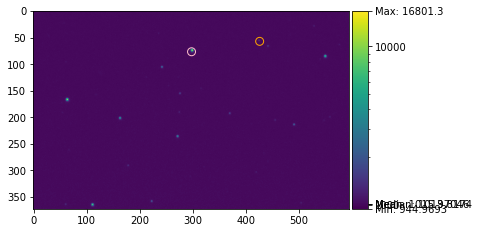

Star: 294
Star from cone pixels: (528.9568619787207, 30.07544502942983)
Star from cone brightness: 39599.35915360536


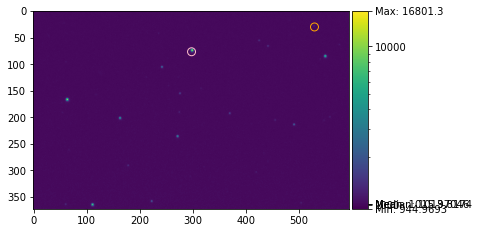

Star: 295
Star from cone pixels: (482.5217279309465, 20.345736228437772)
Star from cone brightness: 25624.50383642436


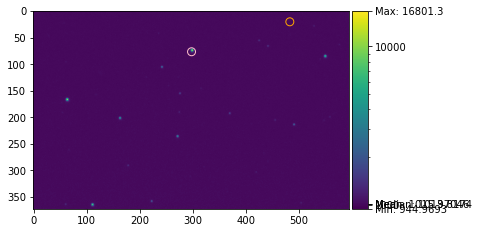

Star: 296
Star from cone pixels: (355.83639413465824, -27.07652697582762)
Star 296 has to be skipped because it is not inside the cutout
Star: 297
Star from cone pixels: (519.3680603449977, -20.91933790142616)
Star 297 has to be skipped because it is not inside the cutout
Star: 298
Star from cone pixels: (552.8224210013242, -28.553109570331344)
Star 298 has to be skipped because it is not inside the cutout
Star: 299
Star from cone pixels: (431.3179173436489, -70.6414111948302)
Star 299 has to be skipped because it is not inside the cutout
Star: 300
Star from cone pixels: (444.45250731609394, -70.91783855611448)
Star 300 has to be skipped because it is not inside the cutout
Star: 301
Star from cone pixels: (372.7486074104768, -93.51852480855382)
Star 301 has to be skipped because it is not inside the cutout
Star: 302
Star from cone pixels: (403.6112814801601, -122.61155395635296)
Star 302 has to be skipped because it is not inside the cutout
Star: 303
Star from cone pixels: (392.4391981

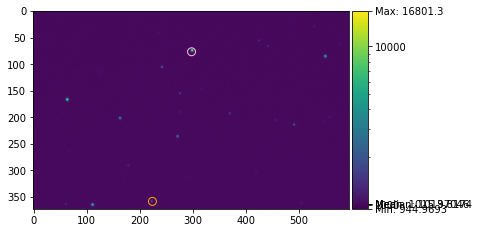

Star: 335
Star from cone pixels: (261.07005084307673, 305.10277919170585)
Star from cone brightness: 9767.92238052864


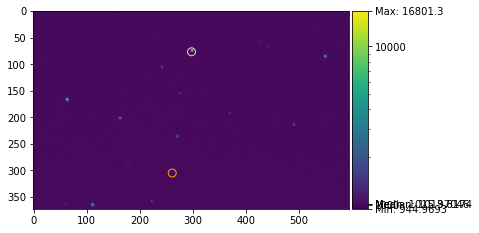

Star: 336
Star from cone pixels: (272.23222892063217, 236.78105227370133)
Star from cone brightness: 159291.00881751985


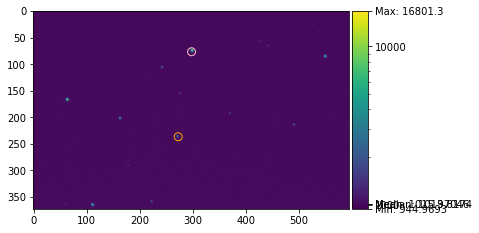

Star: 337
Star from cone pixels: (275.2408368363735, 191.81265471874053)
Star from cone brightness: 78643.01996556057


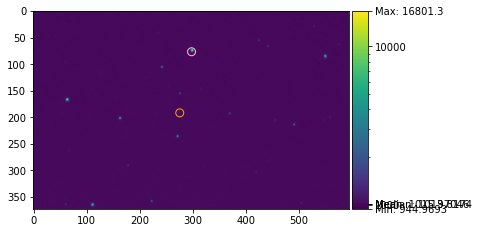

Star: 338
Star from cone pixels: (277.00382252739854, 156.4217021192419)
Star from cone brightness: 95057.18593159481


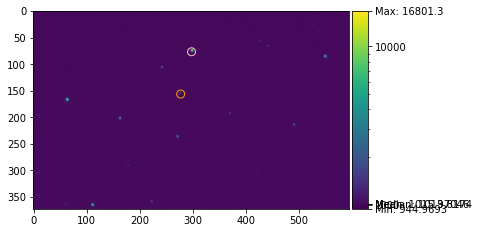

Star: 339
Star from cone pixels: (316.56238651527826, 146.91482995028764)
Star from cone brightness: 77302.31480549702


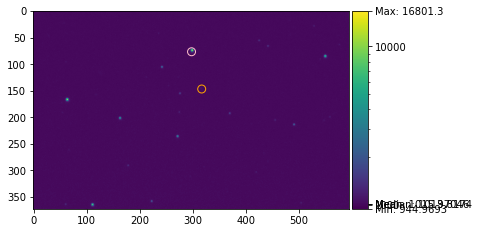

Star: 340
Star from cone pixels: (255.46832812663416, 141.6906682179481)
Star from cone brightness: 38791.66470657285


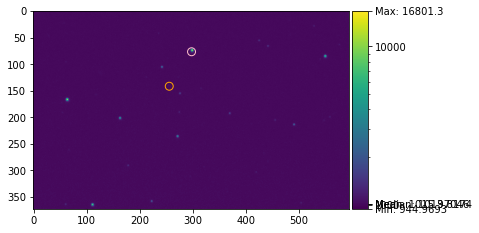

Star: 341
Star from cone pixels: (240.73301745099675, 108.1496025537947)
Star from cone brightness: 253169.5924272367


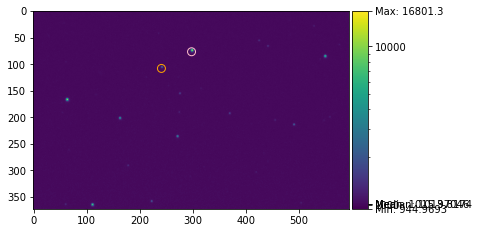

Star: 342
Star from cone pixels: (297.4384818810641, 76.76755652935299)
Star from cone brightness: 321264.7192348744


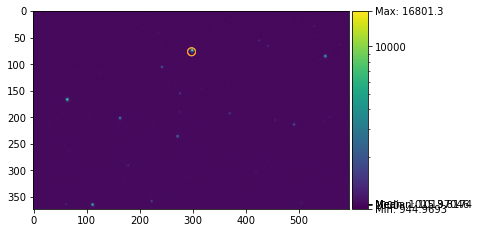

Star: 343
Star from cone pixels: (236.91945895700547, 43.741260163875495)
Star from cone brightness: 57858.49929793287


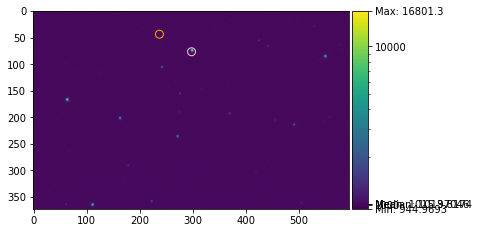

Star: 344
Star from cone pixels: (315.8319964944635, -211.6422823295461)
Star 344 has to be skipped because it is not inside the cutout
Star: 345
Star from cone pixels: (343.1693697430135, -293.8349226669461)
Star 345 has to be skipped because it is not inside the cutout
Star: 346
Star from cone pixels: (291.5950369299166, -310.0499445141859)
Star 346 has to be skipped because it is not inside the cutout
Star: 347
Star from cone pixels: (334.7916234639614, -329.3422071862533)
Star 347 has to be skipped because it is not inside the cutout
Star: 348
Star from cone pixels: (276.6310982901032, -478.1206054844022)
Star 348 has to be skipped because it is not inside the cutout
Star: 349
Star from cone pixels: (273.6370327510288, -634.4071360393048)
Star 349 has to be skipped because it is not inside the cutout
Star: 350
Star from cone pixels: (278.3456785220702, -651.0654451113326)
Star 350 has to be skipped because it is not inside the cutout
Star: 351
Star from cone pixels: (336.7191534943

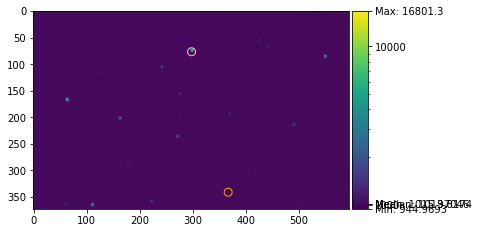

Star: 381
Star from cone pixels: (220.71799783366598, 371.8156283559781)
Star from cone brightness: 47196.8871263484


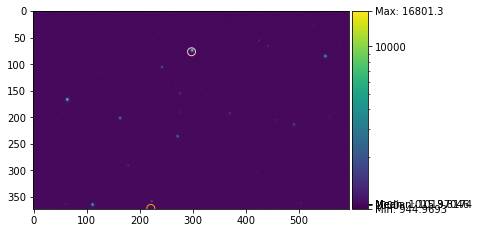

Star: 382
Star from cone pixels: (230.8027840511998, 351.193573278249)
Star from cone brightness: 288467.43862092216


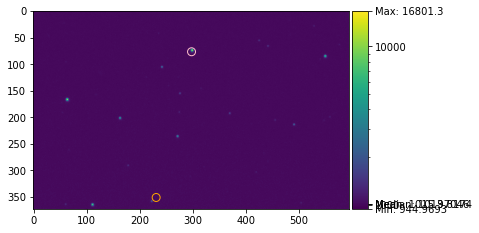

Star: 383
Star from cone pixels: (296.0212244249658, 312.5559128251896)
Star from cone brightness: 38870.07813503884


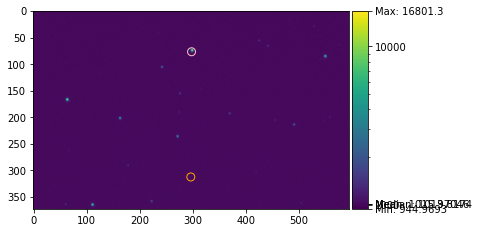

Star: 384
Star from cone pixels: (276.3502673957226, 332.9139895802746)
Star from cone brightness: 12864.534460461058


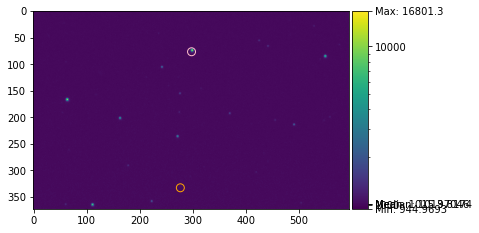

Star: 385
Star from cone pixels: (251.16840028058147, 219.15393280498074)
Star from cone brightness: 12755.36183399867


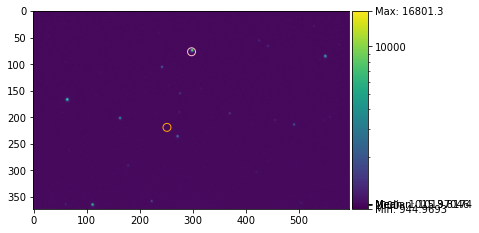

Star: 386
Star from cone pixels: (255.926283606806, 167.9807521032842)
Star from cone brightness: 6469.260468623246


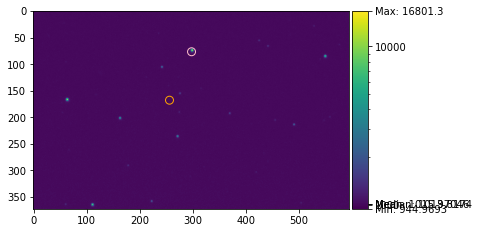

Star: 387
Star from cone pixels: (273.9484599882689, 180.41579056385513)
Star from cone brightness: 76421.62888153235


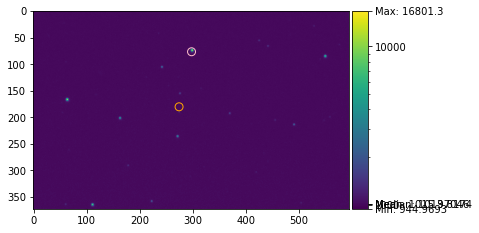

Star: 388
Star from cone pixels: (275.2408368363735, 191.81265471874053)
Star from cone brightness: 78643.01996556057


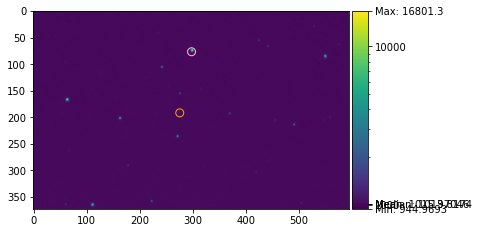

Star: 389
Star from cone pixels: (274.18185596868295, 126.19011067457882)
Star from cone brightness: 32070.305161891534


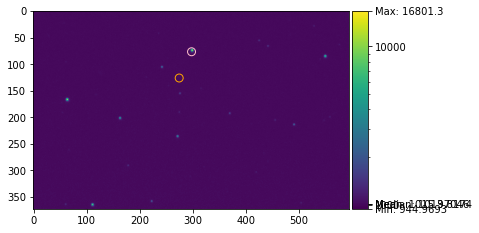

Star: 390
Star from cone pixels: (267.755715004377, 102.67748444202698)
Star from cone brightness: 15966.483390007346


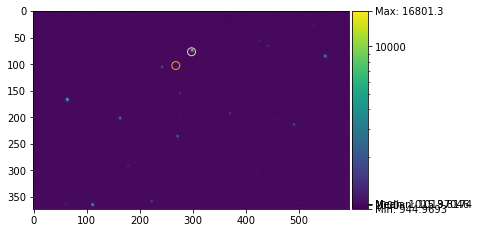

Star: 391
Star from cone pixels: (241.05350951703582, 66.38101504282167)
Star from cone brightness: 9613.289183639645


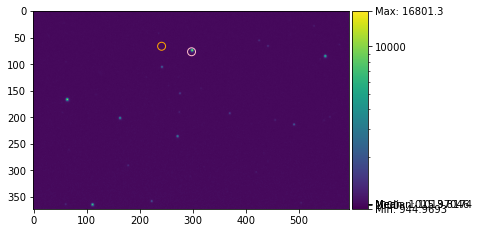

Star: 392
Star from cone pixels: (250.21971644325777, 49.13488556522066)
Star from cone brightness: 9565.109505729333


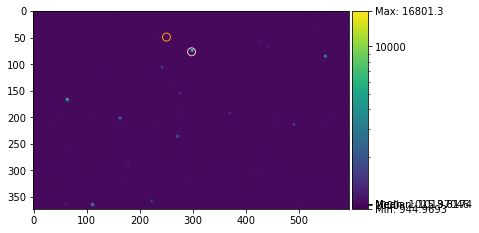

Star: 393
Star from cone pixels: (523.5346592167233, 539.2512701681464)
Star 393 has to be skipped because it is not inside the cutout
Star: 394
Star from cone pixels: (515.9616997369343, 459.5304109584888)
Star 394 has to be skipped because it is not inside the cutout
Star: 395
Star from cone pixels: (485.906998669855, 341.8508856521819)
Star from cone brightness: 57623.991330559


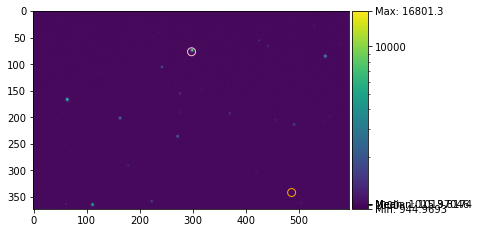

Star: 396
Star from cone pixels: (434.47433439109886, 268.26564712848335)
Star from cone brightness: 48338.92533335878


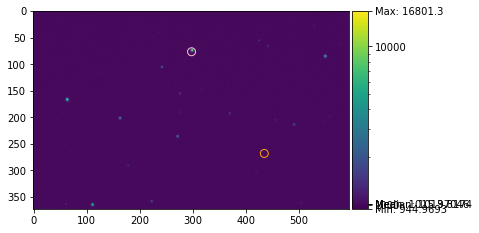

Star: 397
Star from cone pixels: (531.871844317558, 313.00411888105464)
Star from cone brightness: 12795.28001622917


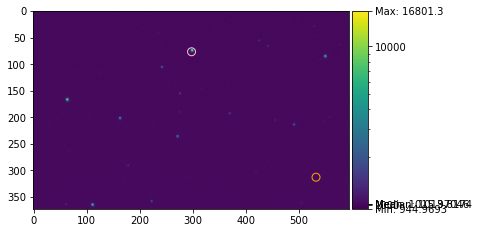

Star: 398
Star from cone pixels: (542.2466712196216, 286.6936737022752)
Star from cone brightness: 6327.564307052158


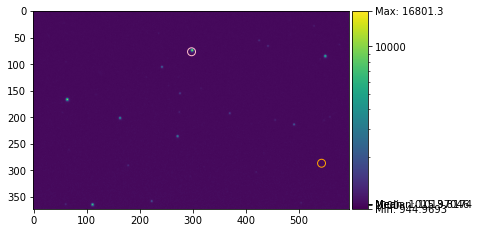

Star: 399
Star from cone pixels: (533.7016836497586, 236.03260947247986)
Star from cone brightness: 12803.381405531378


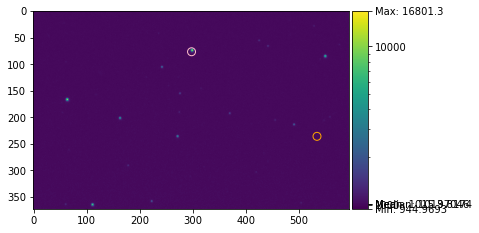

Star: 400
Star from cone pixels: (492.6849872057767, 237.9046973387915)
Star from cone brightness: 6376.242031815647


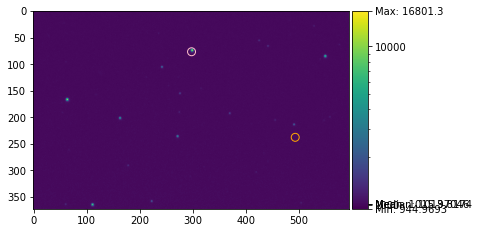

Star: 401
Star from cone pixels: (530.8660508040814, 162.5795618540294)
Star from cone brightness: 12731.937504701746


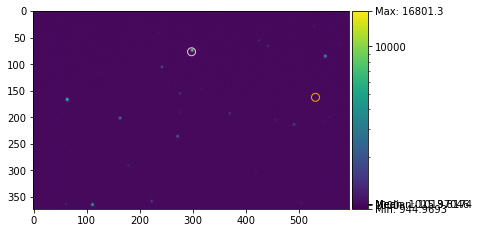

Star: 402
Star from cone pixels: (370.09159129650055, 194.77644180158518)
Star from cone brightness: 197433.4549596517


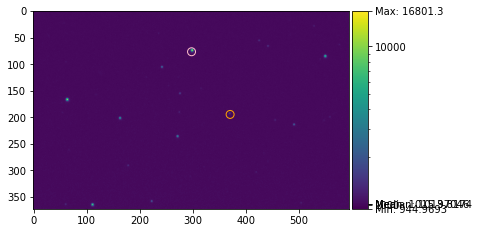

Star: 403
Star from cone pixels: (411.7963944047047, 214.12604826737766)
Star from cone brightness: 32120.15294425805


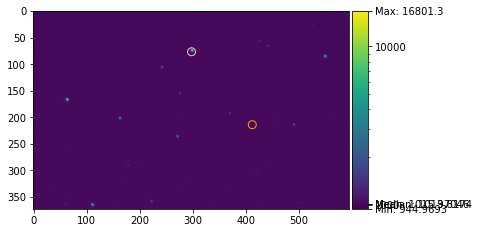

Star: 404
Star from cone pixels: (453.1836225317078, 196.67462249599316)
Star from cone brightness: 66910.81751374753


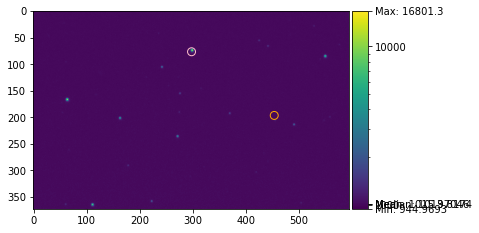

Star: 405
Star from cone pixels: (358.8525560305641, 182.0086152332201)
Star from cone brightness: 6408.5936117164165


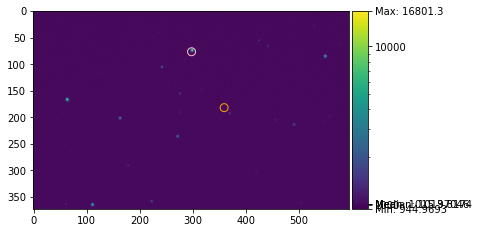

Star: 406
Star from cone pixels: (548.9797911527977, 122.22606106103763)
Star from cone brightness: 25645.294012493374


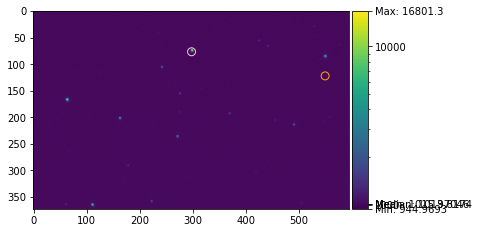

Star: 407
Star from cone pixels: (517.24968206938, 116.0088064117565)
Star from cone brightness: 3239.23762774793


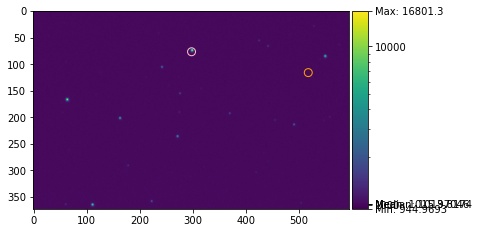

Star: 408
Star from cone pixels: (454.36888110049955, 37.910121923748875)
Star from cone brightness: 3219.209236141022


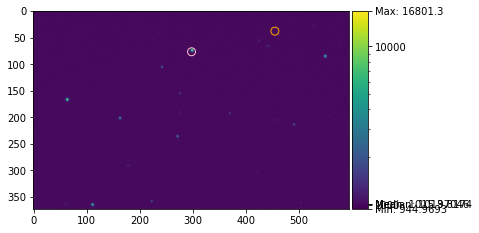

Star: 409
Star from cone pixels: (444.71256086378366, 36.32292598660115)
Star from cone brightness: 3219.2367945745746


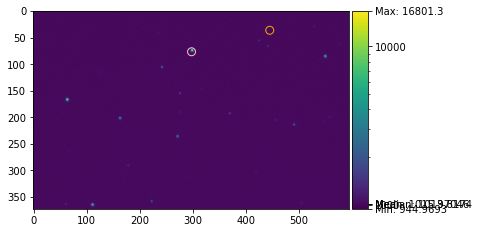

Star: 410
Star from cone pixels: (505.34557256316657, 57.70481230704945)
Star from cone brightness: 6382.496936920884


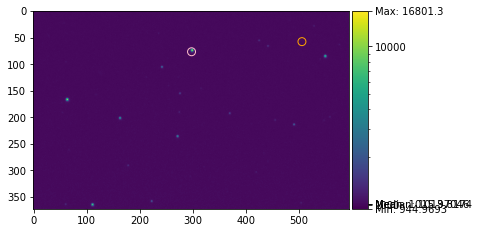

Star: 411
Star from cone pixels: (538.0886059259569, -47.46134504365068)
Star 411 has to be skipped because it is not inside the cutout
Star: 412
Star from cone pixels: (287.0032681325419, 22.327079997811325)
Star from cone brightness: 6403.021370512721


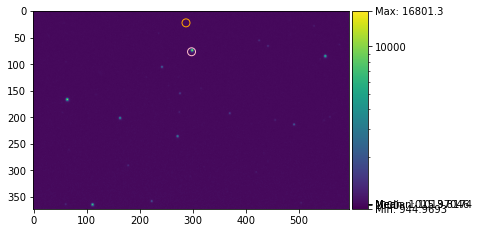

Star: 413
Star from cone pixels: (375.70405156654033, 46.081627196785576)
Star from cone brightness: 3186.1204047285673


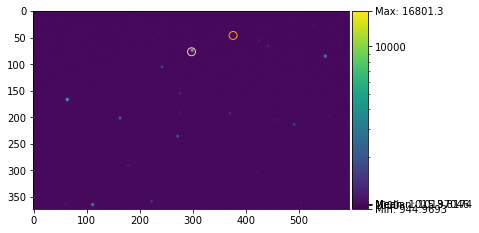

Star: 414
Star from cone pixels: (296.4230732958772, -12.790019349981549)
Star 414 has to be skipped because it is not inside the cutout
Star: 415
Star from cone pixels: (299.5151901081195, -30.45232889353747)
Star 415 has to be skipped because it is not inside the cutout
Star: 416
Star from cone pixels: (254.4665792304037, -34.03188117041668)
Star 416 has to be skipped because it is not inside the cutout
Star: 417
Star from cone pixels: (278.28426220086436, -46.95703689685229)
Star 417 has to be skipped because it is not inside the cutout
Star: 418
Star from cone pixels: (271.3278532642952, -54.52422258921183)
Star 418 has to be skipped because it is not inside the cutout
Star: 419
Star from cone pixels: (296.2070695997187, -67.05243815675772)
Star 419 has to be skipped because it is not inside the cutout
Star: 420
Star from cone pixels: (436.36591325548443, -138.72520644518477)
Star 420 has to be skipped because it is not inside the cutout
Star: 421
Star from cone pixels: (251.662768

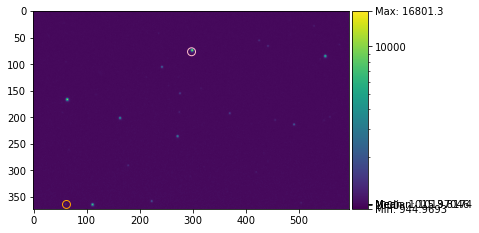

Star: 496
Star from cone pixels: (112.47776731773733, 365.0683450230622)
Star from cone brightness: 242474.35662605197


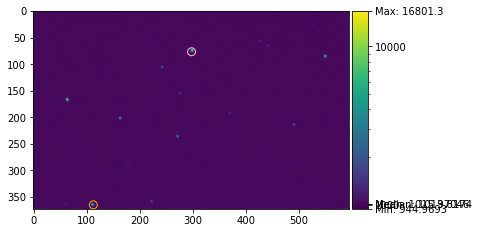

Star: 497
Star from cone pixels: (179.187829005506, 291.5698094083666)
Star from cone brightness: 93116.63224953775


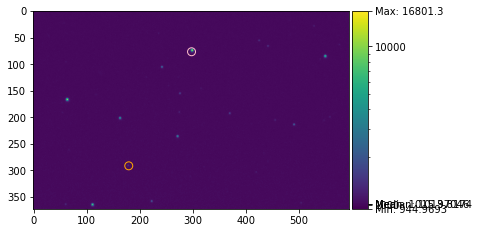

Star: 498
Star from cone pixels: (68.02284179531637, 262.5906403007964)
Star from cone brightness: 39190.720904824186


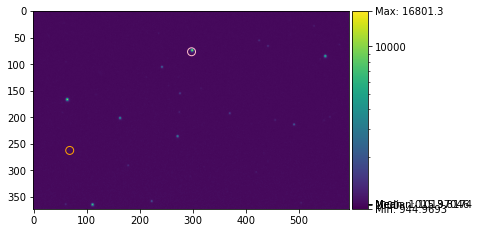

Star: 499
Star from cone pixels: (164.44912673383007, 202.34925207909805)
Star from cone brightness: 391411.01531215466


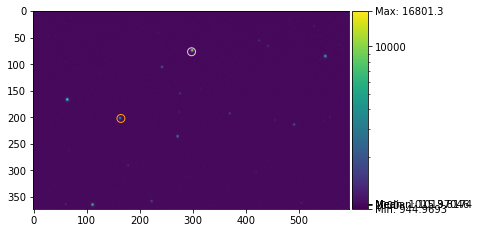

Star: 500
Star from cone pixels: (56.06940011975193, 192.56416427236786)
Star from cone brightness: 38814.7516994606


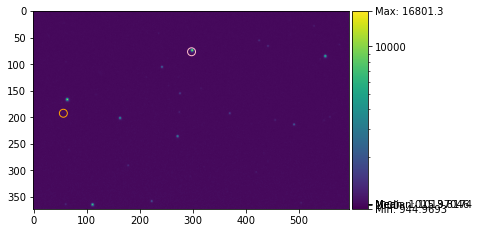

Star: 501
Star from cone pixels: (55.171961547907756, 173.14772645354242)
Star from cone brightness: 225700.16171064047


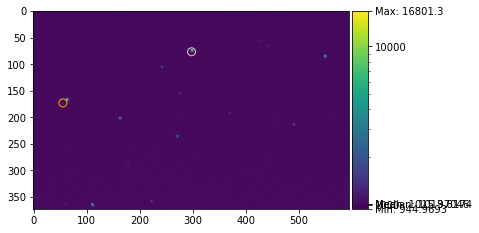

Star: 502
Star from cone pixels: (64.8697626344803, 168.0426261129585)
Star from cone brightness: 326664.34477544355


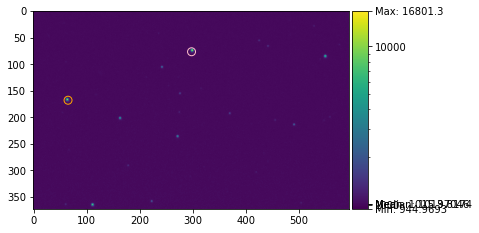

Star: 503
Star from cone pixels: (119.20468673466426, 158.7812653174708)
Star from cone brightness: 76990.1861675787


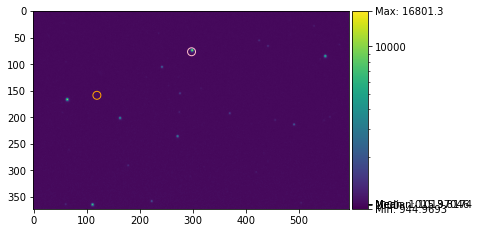

Star: 504
Star from cone pixels: (-17.517495958227357, 71.36128430584972)
Star 504 has to be skipped because it is not inside the cutout
Star: 505
Star from cone pixels: (134.59034235422519, 56.40274072297916)
Star from cone brightness: 19098.000085821852


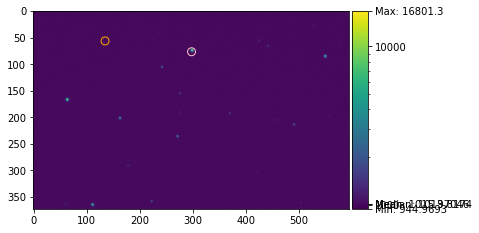

Star: 506
Star from cone pixels: (29.984008654264294, 47.89611812419025)
Star from cone brightness: 79907.9258402412


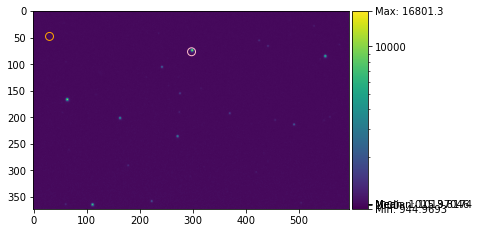

Star: 507
Star from cone pixels: (98.51297248596515, 40.97297615189359)
Star from cone brightness: 9571.412793154512


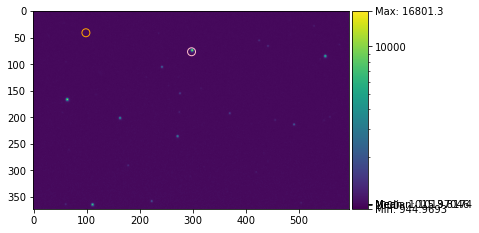

Star: 508
Star from cone pixels: (115.84626461018755, -32.68871094056044)
Star 508 has to be skipped because it is not inside the cutout
Star: 509
Star from cone pixels: (8.55514145898087, -70.15886682298242)
Star 509 has to be skipped because it is not inside the cutout
Star: 510
Star from cone pixels: (119.05539241573922, -104.3627498417286)
Star 510 has to be skipped because it is not inside the cutout
Star: 511
Star from cone pixels: (128.68710805365197, -171.25084935652944)
Star 511 has to be skipped because it is not inside the cutout
Star: 512
Star from cone pixels: (44.945045558474625, -179.7445875399519)
Star 512 has to be skipped because it is not inside the cutout
Star: 513
Star from cone pixels: (62.4087600948161, -223.37215811793953)
Star 513 has to be skipped because it is not inside the cutout
Star: 514
Star from cone pixels: (238.52090041995572, -217.64926484593298)
Star 514 has to be skipped because it is not inside the cutout
Star: 515
Star from cone pixels: (108.5743

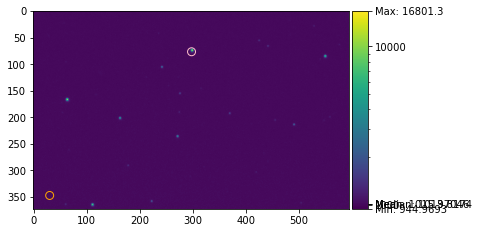

Star: 588
Star from cone pixels: (103.93862259217448, 375.21473931176047)
Star 588 has to be skipped because it is not inside the cutout
Star: 589
Star from cone pixels: (85.08487125510594, 326.5327036112931)
Star from cone brightness: 6451.6650833725225


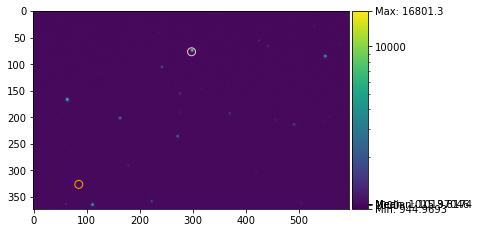

Star: 590
Star from cone pixels: (116.87611094196204, 293.04674453733423)
Star from cone brightness: 6396.066185529425


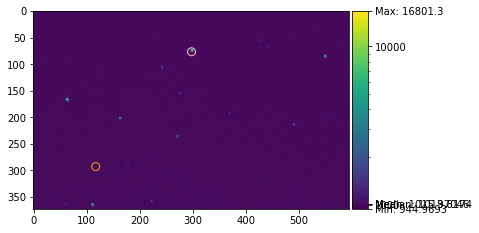

Star: 591
Star from cone pixels: (206.22106821304365, 462.5573777446705)
Star 591 has to be skipped because it is not inside the cutout
Star: 592
Star from cone pixels: (201.23849695917477, 458.63389355501977)
Star 592 has to be skipped because it is not inside the cutout
Star: 593
Star from cone pixels: (200.5446787879525, 460.07724748189)
Star 593 has to be skipped because it is not inside the cutout
Star: 594
Star from cone pixels: (160.9169074281362, 350.43655495293774)
Star from cone brightness: 57720.67794503582


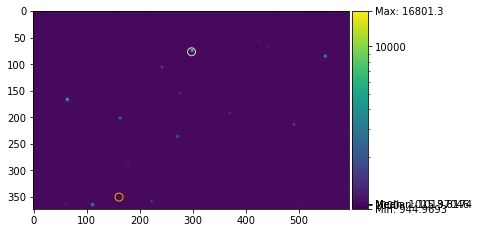

Star: 595
Star from cone pixels: (174.99412777599156, 287.36876206009265)
Star from cone brightness: 91633.06569305476


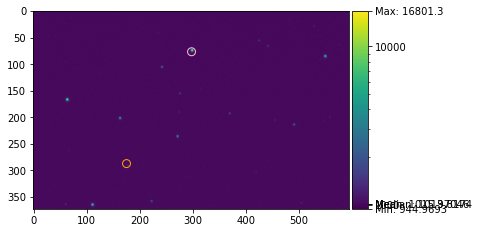

Star: 596
Star from cone pixels: (179.7628132635354, 297.7926188555027)
Star from cone brightness: 90705.6586312288


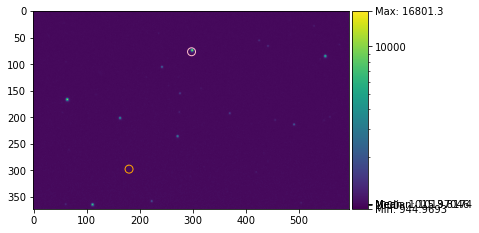

Star: 597
Star from cone pixels: (193.12436982062303, 232.1251095309333)
Star from cone brightness: 19208.983652866697


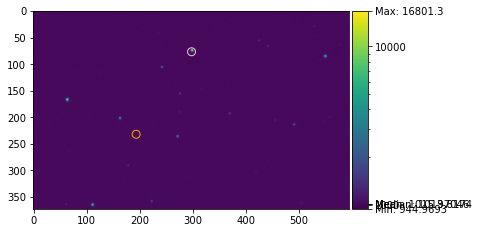

Star: 598
Star from cone pixels: (11.87626205673211, 349.828716683691)
Star from cone brightness: 115327.88513567527


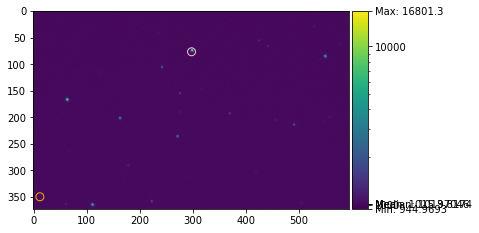

Star: 599
Star from cone pixels: (-91.16872983800056, 273.97238025064644)
Star 599 has to be skipped because it is not inside the cutout
Star: 600
Star from cone pixels: (60.002938201659305, 292.1986359986804)
Star from cone brightness: 9587.892537979256


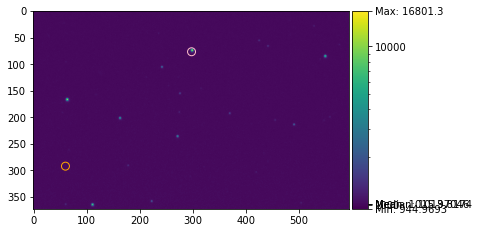

Star: 601
Star from cone pixels: (11.30837867036788, 194.2534275515559)
Star from cone brightness: 19246.873676272124


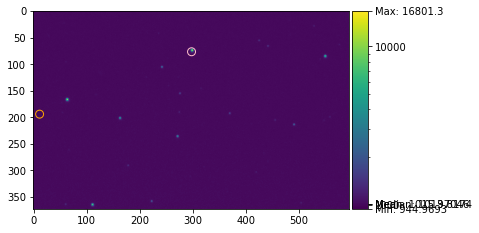

Star: 602
Star from cone pixels: (51.63967668817714, 109.226353717449)
Star from cone brightness: 31875.730242672144


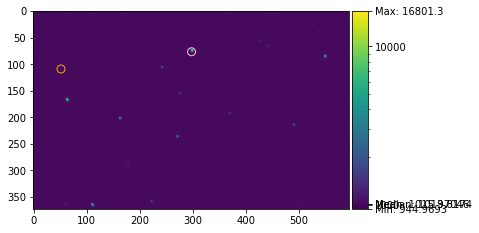

Star: 603
Star from cone pixels: (-65.99835708194674, 157.0961790475867)
Star 603 has to be skipped because it is not inside the cutout
Star: 604
Star from cone pixels: (-8.709156815049582, 118.87212052355153)
Star 604 has to be skipped because it is not inside the cutout
Star: 605
Star from cone pixels: (-8.243360719879092, 99.01140738601816)
Star 605 has to be skipped because it is not inside the cutout
Star: 606
Star from cone pixels: (-85.11468410759952, -2.499212049814332)
Star 606 has to be skipped because it is not inside the cutout
Star: 607
Star from cone pixels: (-26.921343071169886, -49.97982628589216)
Star 607 has to be skipped because it is not inside the cutout
Star: 608
Star from cone pixels: (-20.809111788811293, -40.41727473341916)
Star 608 has to be skipped because it is not inside the cutout
Star: 609
Star from cone pixels: (-21.711842484853804, -31.902281869270837)
Star 609 has to be skipped because it is not inside the cutout
Star: 610
Star from cone pixels: (166.7

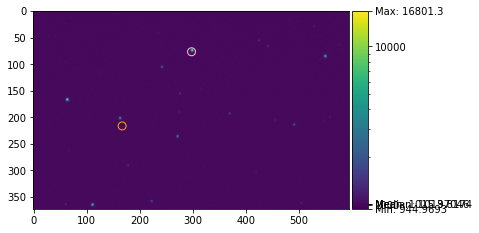

Star: 611
Star from cone pixels: (176.71811710320787, 152.0809649487062)
Star from cone brightness: 38395.93966677717


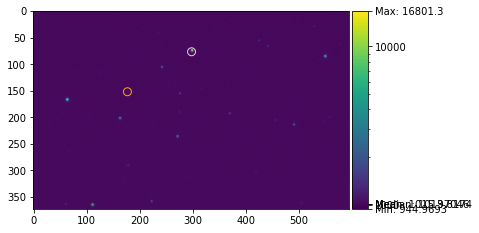

Star: 612
Star from cone pixels: (62.403839827890664, 97.59379577702452)
Star from cone brightness: 29162.94069360884


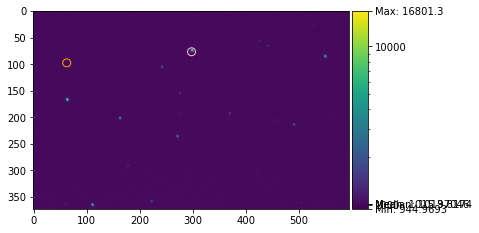

Star: 613
Star from cone pixels: (213.80164099151594, 125.84264685918106)
Star from cone brightness: 38583.6700143439


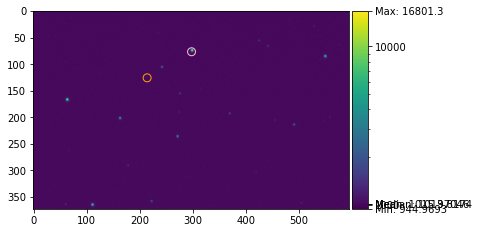

Star: 614
Star from cone pixels: (62.45092946275438, 58.11456646558622)
Star from cone brightness: 9617.658575183366


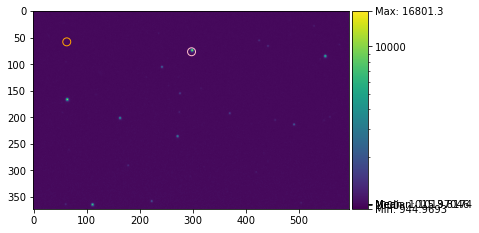

Star: 615
Star from cone pixels: (106.02277812800355, 58.417421633618915)
Star from cone brightness: 3168.0376850578523


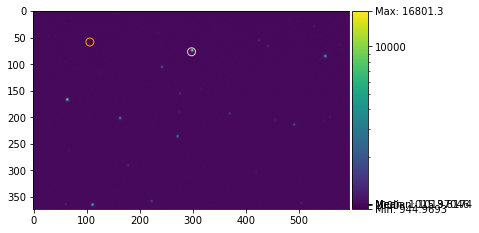

Star: 616
Star from cone pixels: (57.25164151701635, -40.79141452879753)
Star 616 has to be skipped because it is not inside the cutout
Star: 617
Star from cone pixels: (167.36553600485158, -14.776197066851864)
Star 617 has to be skipped because it is not inside the cutout
Star: 618
Star from cone pixels: (109.82590766909712, -101.60406479796848)
Star 618 has to be skipped because it is not inside the cutout
Star: 619
Star from cone pixels: (151.5498843477045, -147.25177199839936)
Star 619 has to be skipped because it is not inside the cutout
Star: 620
Star from cone pixels: (-27.04068251424505, -111.32180493669512)
Star 620 has to be skipped because it is not inside the cutout
Star: 621
Star from cone pixels: (67.23508130399782, -143.764888751816)
Star 621 has to be skipped because it is not inside the cutout
Star: 622
Star from cone pixels: (-19.51668566005617, -223.2260070241814)
Star 622 has to be skipped because it is not inside the cutout
Star: 623
Star from cone pixels: (-56.906

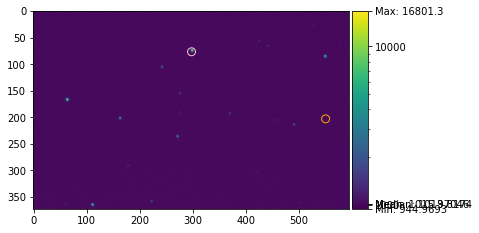

Star: 842
Star from cone pixels: (-193.32880083668977, 467.33648772345305)
Star 842 has to be skipped because it is not inside the cutout
Star: 843
Star from cone pixels: (-178.53558316434805, -204.62996989365752)
Star 843 has to be skipped because it is not inside the cutout
Star: 844
Star from cone pixels: (-156.97376890759992, -446.8361571179821)
Star 844 has to be skipped because it is not inside the cutout
Star: 845
Star from cone pixels: (-28.021895416055813, -501.3986917890825)
Star 845 has to be skipped because it is not inside the cutout
Star: 846
Star from cone pixels: (850.0014692903096, -447.76288143859915)
Star 846 has to be skipped because it is not inside the cutout
..................
done


In [6]:
cone = tic_advanced_search_position_rows()
#open("cone2.txt", "w").write(str(cone)) # Save the cone as a file because it is too large
print(len(cone))
#print(cone.loc[cone["ID"] == 155657581]) # IS A NUMBER NOT STRING, whole row
#print(np.where(cone["ID"] == 155657581)[0][0]) # Actual row int
target_star_index = 342 #int(np.where(cone["ID"] == 155657581)[0][0]) #np.where(cone["ID"] == int(tic_ID.split()[1]))[0][0])

'''
for star_index in range(102, 348): #range(len(cone)): # For each star in cone -- all different stars
    if not os.path.exists("SIMBAD4_Images/" + str(star_index)):
        os.makedirs("SIMBAD4_Images/" + str(star_index))
    #fits_URLs = get_ZTF_links(str(cone.at[star_index, "ra"]), str(cone.at[star_index, "dec"]), str(cutout_size))
    lightcurve_data = get_ZTF_links(star_index, str(cone.at[star_index, "ra"]), str(cone.at[star_index, "dec"]), str(cutout_size))
    if len(lightcurve_data["brightness"]) == 0:
        print("Skipped")
    else:
        all_star_data.append(lightcurve_data)
        with open("ALL_STAR_DATA.pkl", "wb") as my_file:
            pickle.dump(all_star_data, my_file)
'''

#star_index = 342 # Would be in for loop
# BEFOER FOR LOOP -- FIRST CHECK
'''
if not os.path.exists("SIMBAD4_Images/" + str(np.where(cone["ID"] == 155657581)[0][0]) + "_2"):
    os.makedirs("SIMBAD4_Images/" + str(np.where(cone["ID"] == 155657581)[0][0]) + "_2")
lightcurve_data = get_ZTF_links(True, np.where(cone["ID"] == 155657581)[0][0], str(cone.at[np.where(cone["ID"] == 155657581)[0][0], "ra"]), str(cone.at[np.where(cone["ID"] == 155657581)[0][0], "dec"]), str(cutout_size))
if len(lightcurve_data["brightness"]) == 0:
    print("Skipped")
else:
    all_star_data.append(lightcurve_data)
    with open("342_2.pkl", "wb") as my_file:
        pickle.dump(all_star_data, my_file)
'''
#'''
print("Target star is at index " + str(target_star_index))
if not os.path.exists("SIMBAD4_Images/" + str(target_star_index) + "_3"):
    os.makedirs("SIMBAD4_Images/" + str(target_star_index) + "_3")
######lightcurve_data = get_ZTF_links(True, star_index, str(cone.at[star_index, "ra"]), str(cone.at[star_index, "dec"]), str(cutout_size))
get_ZTF_links(target_star_index, str(cone.at[target_star_index, "ra"]), str(cone.at[target_star_index, "dec"]), str(cutout_size))

'''star_index = 342
if not os.path.exists("SIMBAD4_Images/" + str(star_index) + "_3"):
    os.makedirs("SIMBAD4_Images/" + str(star_index) + "_3")
######lightcurve_data = get_ZTF_links(True, star_index, str(cone.at[star_index, "ra"]), str(cone.at[star_index, "dec"]), str(cutout_size))
lightcurve_data = get_ZTF_links(False, star_index, str(cone.at[star_index, "ra"]), str(cone.at[star_index, "dec"]), str(cutout_size))
if len(lightcurve_data["brightness"]) == 0:
    print("Skipped")
else:
    lightcurve_data["Tmag"] = cone.at[star_index, "Tmag"]
    all_star_data.append(lightcurve_data)
    with open(str(star_index) + "_3.pkl", "wb") as my_file:
        pickle.dump(all_star_data, my_file)'''
# INSIDE FOR LOOP -- like make a version of the function that uses the target w
'''
for star_index in range(225, len(cone)): #300):
    if not star_index == np.where(cone["ID"] == int(tic_ID.split()[1]))[0][0]:
        if not os.path.exists("SIMBAD4_Images/" + str(star_index)):
            os.makedirs("SIMBAD4_Images/" + str(star_index))
        lightcurve_data = get_ZTF_links(False, star_index, str(cone.at[star_index, "ra"]), str(cone.at[star_index, "dec"]), str(cutout_size))
        if len(lightcurve_data["brightness"]) == 0:
            print("Skipped")
        else:
            all_star_data.append(lightcurve_data) # cone magnitude!!
            with open("SIMBAD4_Images/" + str(star_index) + "/" + str(star_index) + ".pkl", "wb") as my_file:
                pickle.dump(all_star_data, my_file)
    else:
        print("lol should skip")
#'''
print("done")

ID            1001612233
version         20190415
HIP                 None
TYC                 None
UCAC                None
                 ...    
e_RA_orig        0.57304
e_Dec_orig      0.459102
raddflag             1.0
wdflag               0.0
objID          149426091
Name: 217, Length: 125, dtype: object
Skip count: 934


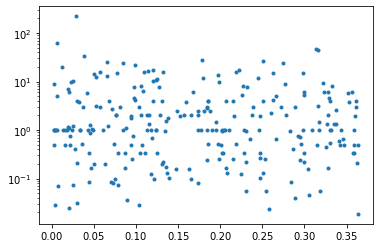

In [42]:
#print(cone.loc[cone["ID"] == 155657581]) # IS A NUMBER NOT STRING, column 342
#print(all_star_data)
#print(len(all_star_data))
#open("ALL_STAR_DATA")
print(cone.iloc[217])

#with open('ALL_STAR_DATA.pkl', 'rb') as f:
#    loaded_dict = pickle.load(f)
#    print(len(loaded_dict))
star_98 = {}
with open("98.pkl", "rb") as file:
    loaded_dict = pickle.load(file)
    star_98 = loaded_dict
star_103 = {}
with open("103_2.pkl", "rb") as file:
    loaded_dict = pickle.load(file)
    star_103 = loaded_dict
star_108 = {}
with open("108_3.pkl", "rb") as file:
    loaded_dict = pickle.load(file)
    star_108 = loaded_dict
SIMBAD4_star = {}
with open("342_2.pkl", "rb") as file:
    loaded_dict = pickle.load(file)
    SIMBAD4_star = loaded_dict

shortest_index = np.min([len(SIMBAD4_star[0]["brightness"]), len(star_108[0]["brightness"]), len(star_103[0]["brightness"])])
figre, ax = plot.subplots()
plot_times = [] #np.array(SIMBAD4_star[0]["time"]) % period
plot_brightnesses = [] #SIMBAD4_star[0]["brightness"]
#'''
individual_star = star_103
count = 0
for time_index in range(len(SIMBAD4_star[0]["brightness"])):
    if time_index < len(individual_star[0]["brightness"]):
    #if (time_index < len(star_108[0]["brightness"])) and (time_index < len(star_103[0]["brightness"])):
        if SIMBAD4_star[0]["time"][time_index] in individual_star[0]["time"]:
        #if (SIMBAD4_star[0]["time"][time_index] in star_108[0]["time"]) and (SIMBAD4_star[0]["time"][time_index] in star_103[0]["time"]):
            index_test = individual_star[0]["time"].index(SIMBAD4_star[0]["time"][time_index])
            plot_times.append(SIMBAD4_star[0]["time"][time_index] % period)
            plot_brightnesses.append((SIMBAD4_star[0]["brightness"][time_index]) / (individual_star[0]["brightness"][index_test])) # each reference star is added onto the denominator
            #plot_brightnesses.append((SIMBAD4_star[0]["brightness"][time_index]) / ((star_103[0]["brightness"][time_index]) + (star_108[0]["brightness"][time_index])))
        else:
            count += 1
    else:
        count += 1

print("Skip count: " + str(count))
ax.plot(plot_times, plot_brightnesses, ".")
#ax.plot(star_98[0]["time"], star_98[0]["brightness"], ".") #, color = "r") # blue
#ax.plot(star_103[0]["time"], star_103[0]["brightness"], ".") # orange
#ax.plot(star_108[0]["time"], star_108[0]["brightness"], ".") # green
ax.set_yscale("log")




0 of 1274
(584, 175)
7425.096497216526


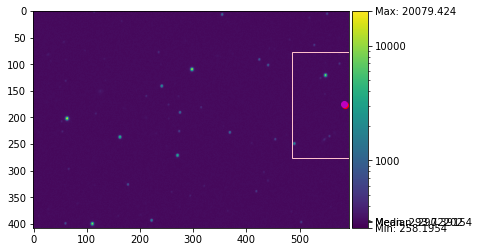

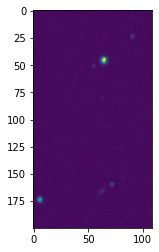




1 of 1274
(584, 175)
7425.096497216526


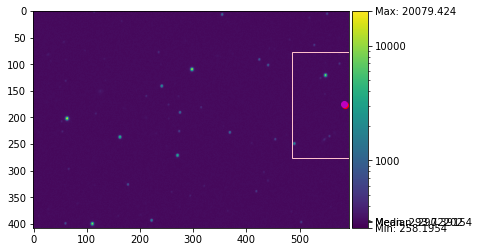

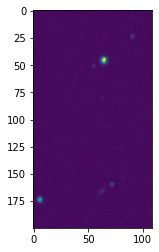

In [331]:
# Make an aperture of the images in the folder
mini_ra = 205.951607576101 #205.975722065762
mini_dec = 79.3823056910152 #79.4493271718068
directory = "SIMBAD4_Images/342"
for filename_index in range(2): #len(os.listdir(directory))):
    print("\n\n\n" + str(filename_index) + " of " + str(len(os.listdir(directory))))
    f = os.path.join(directory, os.listdir(directory)[filename_index])
    if os.path.isfile(f): # Checking if it is a file
        try:
            fits_file = fits.open(f) #fits_URL) # fits can open URLS directly without needing to save the data as a .fits file
            fits_image = np.array(fits_file[0].data)
            w = WCS(fits_file[0].header)
            px, py = w.wcs_world2pix(float(mini_ra), float(mini_dec), 1)
            #print(fits_image.shape)
            testing_px = 0
            testing_py = 0
            mini_max_y, mini_max_x = np.unravel_index((fits_image[int(py)-10:int(py)+10, int(px)-10:int(px)+10]).argmax(), (fits_image[int(py)-10:int(py)+10, int(px)-10:int(px)+10]).shape)
            
            #print("(" + str(mini_max_x) + ", " + str(mini_max_y) + ")")
            max_x = int(px + (mini_max_x - 10))
            max_y = int(py + (mini_max_y - 10))
            
            print("(" + str(max_x) + ", " + str(max_y) + ")")
            while (max_x + testing_px) < len(fits_image[max_y]):
                if fits_image[max_y][max_x + testing_px] > np.median(fits_image):
                    testing_px += 1
                else:
                    break
            
            while (max_y + testing_py) < len(fits_image):
                if fits_image[max_y + testing_py][max_x] > np.median(fits_image):
                    testing_py += 1
                else:
                    break
            
            positions = [(px, py)]
            aperture = EllipticalAperture(positions, testing_px, testing_py, theta = 0.0) #CircularAperture(positions, r = pixel_radius)
            phot_table = aperture_photometry(fits_image, aperture, method = "exact")
            print(phot_table[0]["aperture_sum"]) # THE BRIGHTNESS
            all_star_data[0]["brightness"].append(float(phot_table[0]["aperture_sum"]))
            all_star_data[0]["time"].append(float(fits_file[0].header["OBSJD"]))
            all_star_data[0]["brightness"].append(float(np.median(fits_image)))
            all_star_data[0]["offset"].append(np.median(fits_image) * np.pi * testing_px * testing_py)
            
            
            # Plotting
            figure, ax = plot.subplots()
            ax.plot(px, py, "or")
            ax.plot(max_x, max_y, "om")
            img = ax.imshow(fits_image, norm = matplotlib.colors.LogNorm()) # Log color scale to more easily see the contrast and see more stars. FLip the image data vertically to check with ds9
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size = "5%", pad = 0.05)
            colorbar = figure.colorbar(img, cax = cax, orientation = "vertical")
            colorbar.set_ticks([np.mean(fits_image), np.median(fits_image), 1000, 10000, np.max(fits_image), np.min(fits_image)])
            colorbar.set_ticklabels(["Mean: " + str(np.mean(fits_image)), "Median: " + str(np.median(fits_image)), str(1000), str(10000), "Max: " + str(np.max(fits_image)), "Min: " + str(np.min(fits_image))])
            aperture_plot = matplotlib.patches.Ellipse((max_x, max_y), testing_px, testing_py, fill = False, color = "pink")
            ax.add_patch(aperture_plot)
            a = 100
            closeup_subarray = fits_image[int(py)-a:int(py)+a, int(px)-a:int(px)+a]
            closeup_patch = matplotlib.patches.Rectangle((px-a, py-a), len(closeup_subarray[0]), len(closeup_subarray), fill = False, color = "pink")
            ax.add_patch(closeup_patch)
            plot.show()
            
            #plot.imshow(closeup_subarray)
            figure, ax = plot.subplots()
            img = ax.imshow(closeup_subarray, norm = matplotlib.colors.LogNorm())
            colorbar = figure.colorbar(img, cax = cax, orientation = "vertical")
            colorbar.set_ticks([np.mean(fits_image), np.median(fits_image), 1000, 10000, np.max(fits_image), np.min(fits_image)])
            colorbar.set_ticklabels(["Mean: " + str(np.mean(fits_image)), "Median: " + str(np.median(fits_image)), str(1000), str(10000), "Max: " + str(np.max(fits_image)), "Min: " + str(np.min(fits_image))])
            plot.show()
            
            fits_file.close()
        except:
            print("File " + str(f) + " couldn't be opened as a .fits file")
    else:
        print("File " + str(f) + " couldn't be opened as a file")

In [24]:
print(fits.open("SIMBAD4_Images/342_2/ztf_20190503461644_000862_zg_c14_o_q2_frame1_sciimg.fits")[0].header["filter"]) # SIMBAD4
#print(fits.open("SIMBAD4_Images/98/ztf_20180505344803_000862_zi_c14_o_q3_frame1_sciimg.fits")[0].header["filter"]) # 98
#print(fits.open("SIMBAD4_Images/103_2/ztf_20210705305498_000862_zg_c14_o_q3_frame1_sciimg.fits")[0].header["filter"]) # 103
#print(fits.open("SIMBAD4_Images/108_2/ztf_20200502195440_000862_zr_c14_o_q2_frame1_sciimg.fits")[0].header["filter"]) # 108
#print(fits.open("SIMBAD4_Images/217/ztf_20200626205822_000862_zr_c14_o_q3_frame0_sciimg.fits")[0].header["filter"]) # 217

#print(fits.open("SIMBAD4_Images/225/ztf_20180321371343_000862_zr_c14_o_q3_frame1076_sciimg.fits")[0].header["filter"]) # 225
#print(fits.open("SIMBAD4_Images/285/ztf_20180321371343_000862_zr_c14_o_q3_frame884_sciimg.fits")[0].header["filter"]) # 285
#print(fits.open("SIMBAD4_Images/286/ztf_20180321371343_000862_zr_c14_o_q3_frame819_sciimg.fits")[0].header["filter"]) # 286
#print(fits.open("SIMBAD4_Images/287/ztf_20180321371343_000862_zr_c14_o_q3_frame819_sciimg.fits")[0].header["filter"]) # 287


ZTF_g
ZTF r
ZTF r
ZTF r


Skip count: 925


Text(0, 0.5, 'Brightness Reference star 103 TIC 155656195')

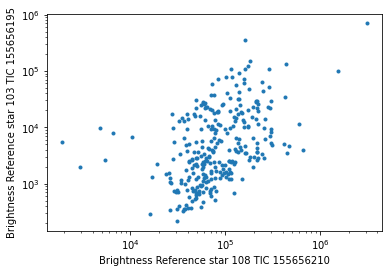

In [40]:
star_108 = {}
with open("108_3.pkl", "rb") as file:
    loaded_dict = pickle.load(file)
    star_108 = loaded_dict
star_103 = {}
with open("103_2.pkl", "rb") as file:
    loaded_dict = pickle.load(file)
    star_103 = loaded_dict

longer_star = star_108
shorter_star = star_103
longer_star_brightnesses = []
shorter_star_brightnesses = []

count = 0
for time_index in range(len(longer_star[0]["brightness"])):
    if time_index < len(shorter_star[0]["brightness"]):
    #if (time_index < len(star_108[0]["brightness"])) and (time_index < len(star_103[0]["brightness"])):
        if longer_star[0]["time"][time_index] in shorter_star[0]["time"]:
            index_test = shorter_star[0]["time"].index(longer_star[0]["time"][time_index])
            longer_star_brightnesses.append(longer_star[0]["brightness"][time_index])
            shorter_star_brightnesses.append(shorter_star[0]["brightness"][index_test])
            #plot_brightnesses.append((SIMBAD4_star[0]["brightness"][time_index]) / ((star_103[0]["brightness"][time_index]) + (star_108[0]["brightness"][time_index])))
        else:
            count += 1
    else:
        count += 1

print("Skip count: " + str(count))
figre, ax = plot.subplots()
ax.plot(longer_star_brightnesses, shorter_star_brightnesses, ".")
#ax.plot(star_98[0]["time"], star_98[0]["brightness"], ".") #, color = "r") # blue
#ax.plot(star_103[0]["time"], star_103[0]["brightness"], ".") # orange
#ax.plot(star_108[0]["time"], star_108[0]["brightness"], ".") # green
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("Brightness Reference star 108 TIC 155656210")
ax.set_ylabel("Brightness Reference star 103 TIC 155656195")
#plot.show()

In [39]:
time_differences = []

for time_index in range(len(longer_star[0]["brightness"])):
    if time_index < len(shorter_star[0]["brightness"]):
        if longer_star[0]["time"][time_index] in shorter_star[0]["time"]:
            index_test = shorter_star[0]["time"].index(longer_star[0]["time"][time_index])
            print(str(longer_star[0]["time"][time_index]) + "   " + str(shorter_star[0]["time"][index_test]))
            

2458586.6768287   2458586.6768287
2458298.7346065   2458298.7346065
2458592.6838194   2458592.6838194
2458323.6676968   2458323.6676968
2458205.7924074   2458205.7924074
2458885.9522801   2458885.9522801
2458976.7999306   2458976.7999306
2458278.6790046   2458278.6790046
2458557.8238657   2458557.8238657
2458208.7748148   2458208.7748148
2458261.762037   2458261.762037
2458286.8026157   2458286.8026157
2459210.9300579   2459210.9300579
2458557.7197106   2458557.7197106
2458583.8254398   2458583.8254398
2458302.6837269   2458302.6837269
2458857.053206   2458857.053206
2459257.8900694   2459257.8900694
2459216.9084375   2459216.9084375
2459014.7260532   2459014.7260532
2458591.7029282   2458591.7029282
2459375.7842014   2459375.7842014
2458597.8078009   2458597.8078009
2458887.9337384   2458887.9337384
2458582.7807292   2458582.7807292
2458256.7859722   2458256.7859722
2459217.0497569   2459217.0497569
2459338.9307523   2459338.9307523
2459276.7211806   2459276.7211806
2458298.8069676   

In [188]:
base_url = "https://fallingstar-data.com/forcedphot"
%run Passwords.ipynb

response = requests.post(url = str(base_url) + "/api-token-auth/", data = {"username": username, "password": password})
ra = 44
dec = 22
task_url = ""

if response.status_code == 200:
    token = response.json()["token"]
    print("Token: " + str(token))
    headers = {"Authorization": "Token " + str(token), "Accept": "application/json"}
    
    task_url = None
    while not task_url:
        with requests.Session() as session:
            response = session.post(str(base_url) + "/queue/", headers = headers, data = {"ra": ra, "dec": dec, "mjd_min": 59248., "send_email": False})
            
            if response.status_code == 201:  # Successfull!
                task_url = response.json()["url"]
                print("Task URL: " + str(task_url))
                
                response = requests.get(task_url, allow_redirects = True)
                open("test.txt", "wb").write(response.content)
            elif response.status_code == 429:  # Wait
                message = response.json()["detail"]
                print("ERROR: " + str(response.status_code))
                print(response.json())
                seconds = re.findall(r'available in (\d+) seconds', message)
                minutes = re.findall(r'available in (\d+) minutes', message)
                wait_time = 0
                if t_sec:
                    wait_time = int(seconds[0])
                elif t_min:
                    wait_time = int(minutes[0]) * 60
                else:
                    wait_time = 10
                print("Waiting " + str(wait_time) + " seconds...")
                time.sleep(wait_time)
            else: # Fail
                print("ERROR: " + str(response.status_code))
                print(response.json())
                sys.exit()
else:
    print("ERROR: " + str(response.status_code))
    print(response.json())

Token: 5cce47d2becf05b9142e13afd79c6648da9b26db
Task URL: https://fallingstar-data.com/forcedphot/queue/215932/


In [35]:
result_url = None
while not result_url:
    with requests.Session() as session:
        response = session.get(task_url, headers = headers)
        
        if response.status_code == 200: # HTTP OK
            if response.json()["finishtimestamp"]:
                result_url = response.json()["result_url"]
                print("Result URL: " + str(result_url))
                break
            elif response.json()["starttimestamp"]:
                print("Task is running (started at " + str(response.json()["starttimestamp"]))
            else:
                print("Waiting 10 seconds...")
                time.sleep(10)
        else:
            print("ERROR: " + str(response.status_code))
            print(response.json())
            sys.exit()


panda_result = ""

with requests.Session() as session:
    textdata = session.get(result_url, headers = headers).text
    #print(textdata)
    
    session.delete(task_url, headers = headers).json() # De-clutter sessions
    
    panda_result = pd.read_csv(io.StringIO(textdata.replace("###", "")), delim_whitespace = True)
    print(panda_result)

Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...
Waiting 10 seconds...


ConnectionError: HTTPSConnectionPool(host='fallingstar-data.com', port=443): Max retries exceeded with url: /forcedphot/queue/215366/ (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000222E26E2610>: Failed to establish a new connection: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond'))